# 1. Environment Setup

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# 2. Dataset

In [2]:
# Download the dataset
df = pd.read_csv('https://raw.githubusercontent.com/RegiMuhammar/luxtrace-machine-learning/main/Dataset/Dataset%20LuxTrace%20-%20Product%20Demand%20Forecasting.csv', delimiter=',', encoding='utf-8')
raw_data = df.values
df.head(10)


,delivery_date,product_name,total_product_delivery
0,1/1/2023,Atlas Sneaker White,119
1,1/1/2023,Atlas Sneaker White,117
2,1/1/2023,Atlas Sneaker White,143
3,1/4/2023,Atlas Sneaker White,154
4,1/5/2023,Saki Sneakers - Soybean,121
5,1/8/2023,Saki Sneakers - Soybean,136
6,1/8/2023,Saki Sneakers - Soybean,177
7,1/8/2023,Saki Sneakers - Soybean,165
8,1/9/2023,Kotta Hybrid Sneakers - Skeleton,136
9,1/10/2023,Kotta Hybrid Sneakers - Skeleton,135


In [3]:
df.shape

(500, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   delivery_date           500 non-null    object
 1   product_name            500 non-null    object
 2   total_product_delivery  500 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


In [5]:
df.isna().sum() # Check missing value pada data

delivery_date             0
product_name              0
total_product_delivery    0
dtype: int64

In [6]:
print("Jumlah duplikasi data: ", df.duplicated().sum())

Jumlah duplikasi data:  0


In [7]:
df.describe(include='all')

,delivery_date,product_name,total_product_delivery
count,500,500,500.000
unique,361,6,NaN
top,11/29/2023,Atlas Eceng Hi Top Sneaker White,NaN
freq,5,106,NaN
mean,NaN,NaN,336.408
std,NaN,NaN,123.426
min,NaN,NaN,100.000
25%,NaN,NaN,232.500
50%,NaN,NaN,338.500
75%,NaN,NaN,443.000


# 3. Exploratory Data Analysis

In [8]:
# Convert the 'delivery_date' column to datetime format
df['delivery_date'] = pd.to_datetime(df['delivery_date'])

# Set 'Date' column as the index
df.set_index('delivery_date', inplace=True)

df.head()

,product_name,total_product_delivery
delivery_date,,
2023-01-01,Atlas Sneaker White,119
2023-01-01,Atlas Sneaker White,117
2023-01-01,Atlas Sneaker White,143
2023-01-04,Atlas Sneaker White,154
2023-01-05,Saki Sneakers - Soybean,121


In [9]:
df = df.groupby(pd.Grouper(freq='W')).agg({'total_product_delivery':'sum'})

df.head()

,total_product_delivery
delivery_date,
2023-01-01,379
2023-01-08,753
2023-01-15,622
2023-01-22,218
2023-01-29,1129


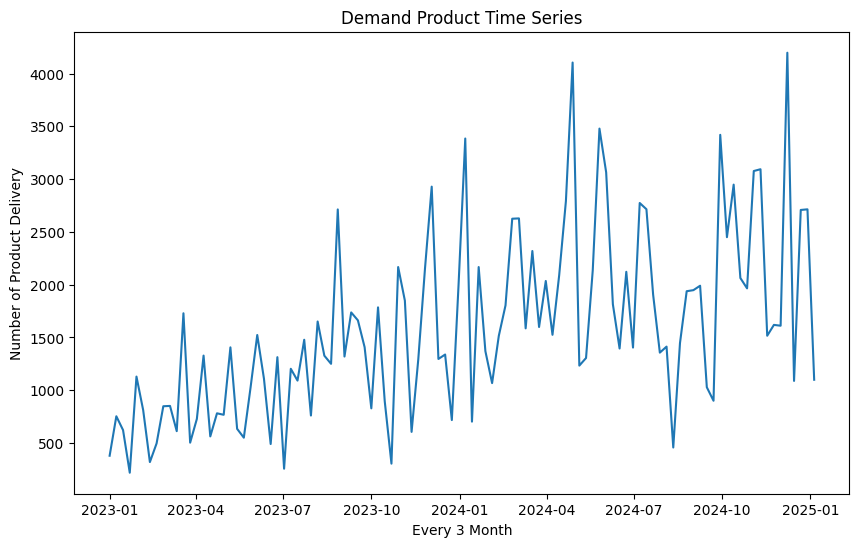

In [10]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['total_product_delivery'])
plt.title('Demand Product Time Series')
plt.xlabel('Every 3 Month')
plt.ylabel('Number of Product Delivery')
plt.show()

# 4. Preprocessing the Data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2023-01-01 to 2025-01-05
Freq: W-SUN
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   total_product_delivery  106 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


In [12]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 5. Creating Sequences for LSTM Model

In [33]:
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[i:i+seq_length])
        y.append(df[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 14  # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# 6. Defining and Training the LSTM Model

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=1)

Epoch 1/500
5/5 [==============================] - 4s 12ms/step - loss: 0.1298 - mse: 0.1298
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0791 - mse: 0.0791
Epoch 3/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0431 - mse: 0.0431
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0504 - mse: 0.0504
Epoch 5/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0392 - mse: 0.0392
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0379 - mse: 0.0379
Epoch 7/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0416 - mse: 0.0416
Epoch 8/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0323 - mse: 0.0323
Epoch 9/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0298 - mse: 0.0298
Epoch 10/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0415 - mse: 0.0415
Epoch 11/500
5/5 [==============================] - 0s 17ms/step - lo

In [35]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
#     tf.keras.layers.LSTM(32),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1)
# ])

# model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# model.fit(X_train, y_train, epochs=500, batch_size=12, verbose=1)

# 7. Predictions and Visualization

1/1 [==============================] - 0s 24ms/step


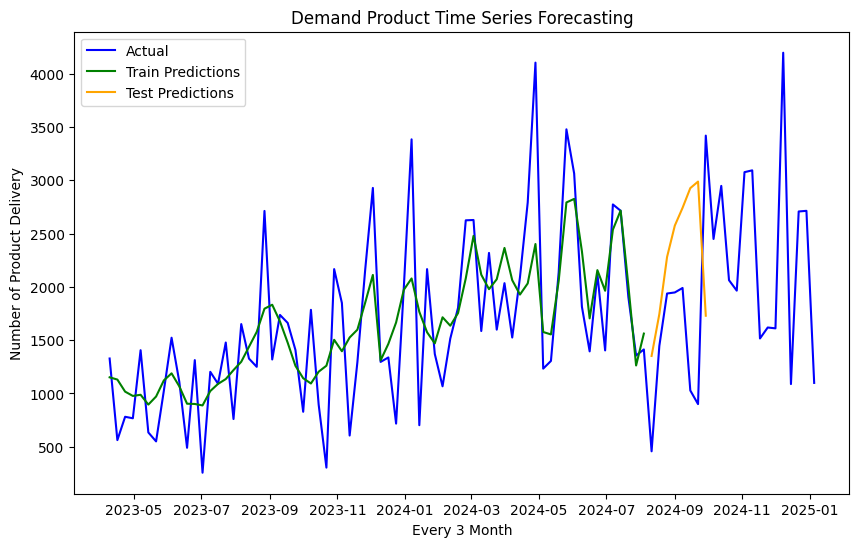

In [36]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(df.index[seq_length:], df['total_product_delivery'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions',color='orange')

plt.title('Demand Product Time Series Forecasting')
plt.xlabel('Every 3 Month')
plt.ylabel('Number of Product Delivery')
plt.legend()
plt.show()

# 8. Forecasting

1/1 [==============================] - 0s 24ms/step


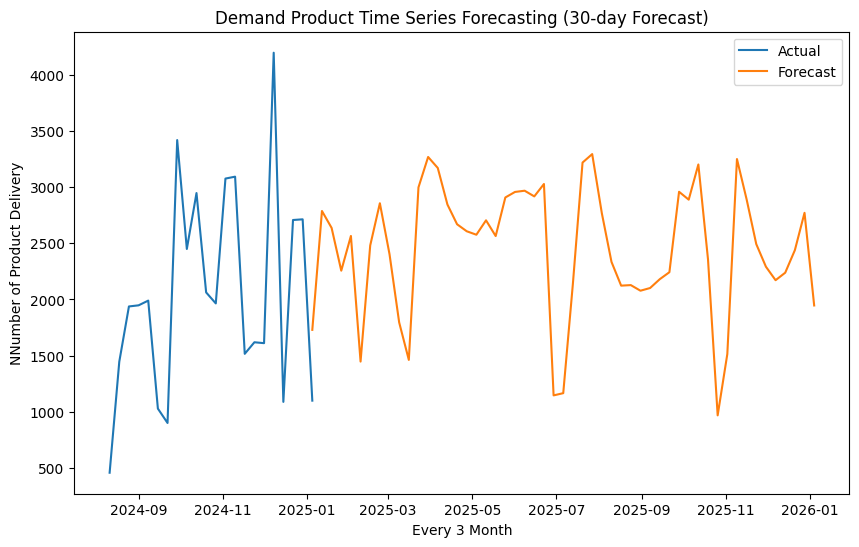

In [39]:
# Forecasted values for the next 1 year
forecast_period = 53
forecast = []

# Use the last sequence from the test data to make predictions
last_sequence = X_test[-1]

for _ in range(forecast_period):
    # Reshape the sequence to match the input shape of the model
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predict the next value
    next_prediction = model.predict(current_sequence)[0][0]
    # Append the prediction to the forecast list
    forecast.append(next_prediction)
    # Update the last sequence by removing the first element and appending the predicted value
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(test_data):], scaler.inverse_transform(test_data), label='Actual')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_period, freq='w'), forecast, label='Forecast')
plt.title('Demand Product Time Series Forecasting (30-day Forecast)')
plt.xlabel('Every 3 Month')
plt.ylabel('NNumber of Product Delivery')
plt.legend()
plt.show()

# Saved and Converter Model TensorflowJS

In [40]:
# Save the model in TensorFlow SavedModel format
import os

model.save("forecasting.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
